In [2]:
''' packages import'''
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch import optim
import random
import matplotlib.pyplot as plt

# a. Data Loader

In [3]:
BATCH_SIZE=32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
mnist_train_data = datasets.FashionMNIST(root="./data",train=True, download=True, transform=torchvision.transforms.ToTensor())
# mnist_test_data = datasets.FashionMNIST(root="./data",train=False, download=True, transform=torchvision.transforms.ToTensor())

/home/hanwen/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(len(mnist_train_data))
# print(len(mnist_test_data))

60000


In [6]:
# (mnist_train_data[0])

In [7]:
trainDataLoader = torch.utils.data.DataLoader(mnist_train_data, batch_size=BATCH_SIZE, shuffle=True)
# testDataLoader = torch.utils.data.DataLoader(mnist_test_data, batch_size=BATCH_SIZE, shuffle=False).to(DEVICE)

In [8]:
print(trainDataLoader.dataset.data.shape) # '''torch.Size([60000, 28, 28])'''
# print(testDataLoader.dataset.data.shape)  # '''torch.Size([10000, 28, 28]) '''

torch.Size([60000, 28, 28])


In [9]:
# for index, (images, labels) in enumerate(trainDataLoader):
#   print((index), images.shape)
#   y = labels.view(32, 1)
#   y = to_onehot(y)
#   print(y)

# Model

## b. Discriminator

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2), bias=False)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(5,5), stride=(2,2), padding=(2,2),bias=False)
    self.LeakyReLu = nn.LeakyReLU(negative_slope=0.3)
    self.dropout = nn.Dropout(p=0.3)
    self.fc = nn.Linear(128*7*7, 1, bias=False)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # print(x.shape) # torch.Size([1, 1, 28, 28])
    x = self.conv1(x)

    x = self.LeakyReLu(x)
    x = self.dropout(x)

    x = self.conv2(x)
    # print(x.shape)
    x = self.LeakyReLu(x)
    x = self.dropout(x)
    x = x.view(-1, 128*7*7)  # manually flatten x to 128*7*7 = 6272
    # print(x.shape)
    x = self.fc(x)
    x = self.sigmoid(x)

    return x

In [11]:
netD = Discriminator().to(DEVICE)
out = netD(mnist_train_data[0][0].unsqueeze(0).to(DEVICE))
print(out)

tensor([[0.4871]], device='cuda:0', grad_fn=<SigmoidBackward>)


## c. Generator

In [12]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.noise = torch.normal(0.0,1.0, size=(32, 100))

    self.fc = nn.Linear(100, 256*7*7, bias=False)

    self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=(5,5), stride=(1,1), padding=(2,2), bias=False)
    self.batchnorm1 = nn.BatchNorm2d(128)
    self.LeakyReLU = nn.LeakyReLU(0.3)

    self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=(5,5), stride = (2, 2), 
                                    padding=(2,2),output_padding=(1,1), bias=False)
    self.batchnorm2 = nn.BatchNorm2d(64)

    self.conv3 = nn.ConvTranspose2d(64, 1, kernel_size=(5,5), stride=(2, 2), 
                                    padding=(2,2), output_padding=(1,1), bias=False)
    self.tanh = nn.Tanh()
    
  def forward(self, x=torch.normal(0.0, 1.0, size=(32, 100))):
    # print(x.shape) # torch.Size([100])
    x = self.fc(x)
    x = x.view(-1, 256, 7, 7).to(DEVICE)
    # print(x.shape) # torch.Size([1, 256, 7, 7])

    x = self.conv1(x)
    x = self.batchnorm1(x)
    x= self.LeakyReLU(x)
    # print(x.shape) # torch.Size([1, 128, 7, 7])

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x= self.LeakyReLU(x)
    # print(x.shape)  # torch.Size([1, 64, 14, 14])

    x = self.conv3(x)
    x = self.tanh(x)
    # print(x.shape) # torch.Size([1, 1, 28, 28])

    return x

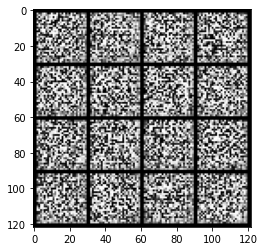

In [13]:
netG = Generator()
netG = netG.to(DEVICE)
a= torch.normal(0.0, 1.0, size=(16, 100))
a=a.to(DEVICE)
a
out = netG(a)
out = out.cpu()
# ply.imshow(out, )
grid_img = torchvision.utils.make_grid(out, nrow=4, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))

# d.e. Training for 50 epochs

In [14]:
cirterion = nn.BCELoss()
optimizerD = optim.Adam(params=netD.parameters(),lr=1e-4)
optimizerG = optim.Adam(params=netG.parameters(), lr=1e-4)

In [15]:
MAX_EPOCHS=50
BATCH_SIZE = 32
n_critic = 1
y_real = torch.ones(BATCH_SIZE,1).to(DEVICE)
y_fake = torch.zeros(BATCH_SIZE,1).to(DEVICE)


In [16]:
import numpy as np
def get_sample_image(G, n_noise=100):
    z = torch.normal(0.0,1.0, size=(16, 100)).to(DEVICE)
    y_hat = G(z)
    # print(y_hat.shape)  #[16, 1, 28, 28]
    y_hat = y_hat.cpu()
    # grid_img = torchvision.utils.make_grid(y_hat, nrow=4, normalize=True)
    # plt.imshow(grid_img.permute(1, 2, 0)) 

    return y_hat


In [17]:
loss_D_lis = []
loss_G_lis = []
yhats = []
step = 0 
import random
random.seed(1234)

for epoch in range(MAX_EPOCHS):
  for index, (images, labels) in enumerate(trainDataLoader):
    # update the netD first
    x = images.to(DEVICE)
    labels = labels.to(DEVICE)
    out_real = netD(x)
    # print(out_real)
    loss_real_D = cirterion(out_real, y_real)

    noise = torch.normal(0.0,1.0, size=(BATCH_SIZE,100)).to(DEVICE)
    out_fake = netD(netG(noise))
    loss_fake_D = cirterion(out_fake, y_fake)

    loss_D = loss_real_D + loss_fake_D
    
    loss_D_lis.append(loss_D.item())

    netD.zero_grad()
    loss_D.backward()
    optimizerD.step()

    if step % n_critic == 0:  # for each n_critic number of iterations, update netG
      noise = torch.normal(0.0,1.0, size=(BATCH_SIZE, 100)).to(DEVICE)
      out_fake = netD(netG(noise))
      loss_G = cirterion(out_fake, y_real)
      
      loss_G_lis.append(loss_G.item())

      netG.zero_grad()
      loss_G.backward()
      optimizerG.step()

    if step % 500==0:
      print('Epoch: {}/{}, step: {}, D loss: {}, G loss: {}'.format(epoch, MAX_EPOCHS,
                                                                    step,
                                                                    loss_D.item(),
                                                                    loss_G.item()))
    step +=1 
  
  if epoch in [0, 4, 9, 29, 49]:
    netG.eval()
    yhat = get_sample_image(netG, 100)
    yhats.append(yhat)
    # imshow(img, cmap ='gray')
    
    netG.train()

    


Epoch: 0/50, step: 0, D loss: 1.393359661102295, G loss: 0.7424590587615967
Epoch: 0/50, step: 500, D loss: 0.9853487610816956, G loss: 1.7699296474456787
Epoch: 0/50, step: 1000, D loss: 1.248870849609375, G loss: 0.7410386800765991
Epoch: 0/50, step: 1500, D loss: 1.0529385805130005, G loss: 0.9771480560302734
Epoch: 1/50, step: 2000, D loss: 0.9925321340560913, G loss: 0.847400963306427
Epoch: 1/50, step: 2500, D loss: 0.9572258591651917, G loss: 1.2025208473205566
Epoch: 1/50, step: 3000, D loss: 1.0722967386245728, G loss: 0.7317071557044983
Epoch: 1/50, step: 3500, D loss: 0.9206662178039551, G loss: 0.9583404660224915
Epoch: 2/50, step: 4000, D loss: 1.0631325244903564, G loss: 1.1134192943572998
Epoch: 2/50, step: 4500, D loss: 0.9357129335403442, G loss: 0.7721644043922424
Epoch: 2/50, step: 5000, D loss: 0.9527695775032043, G loss: 0.8225863575935364
Epoch: 2/50, step: 5500, D loss: 0.9857520461082458, G loss: 0.6699045896530151
Epoch: 3/50, step: 6000, D loss: 1.050501942634

In [27]:
index

1874

0


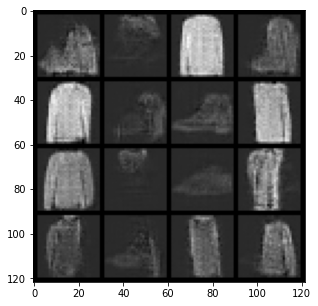

1


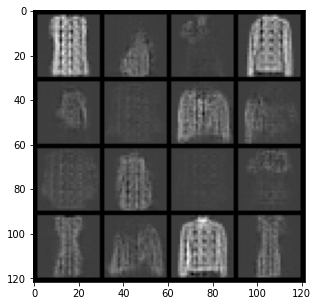

2


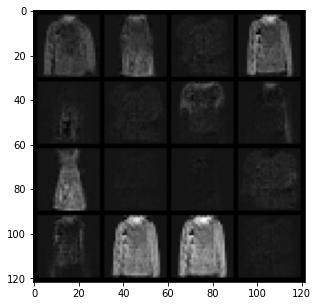

In [51]:
for i, yhat in enumerate(yhats[2:]):
  # plt.subplot(1,3,i)
  print(i)
  plt.figure(figsize=(5,5))
  grid_img = torchvision.utils.make_grid(yhat, nrow=4, normalize=True)
  plt.imshow(grid_img.permute(1, 2, 0)) 
  plt.show()

Notice, (ignore the graying out issue), the generated graphs have to better and better qualities in terms of clearness.

# e. Plot the loss

In [25]:
print(step)
print(len(loss_D_lis))
print(len(mnist_train_data))

93750
93750
60000


## Epoch level loss

In [36]:
CHUNK_SIZE=len(trainDataLoader) # = 1875
epoch_loss_D=[]
epoch_loss_G=[]
cnt = 0
for i in range(step):
  if i % CHUNK_SIZE == 0 :
    try:
      epoch_loss_D.append(np.average(loss_D_lis[cnt*CHUNK_SIZE:(cnt+1)*CHUNK_SIZE]))
      epoch_loss_G.append(np.average(loss_G_lis[cnt*CHUNK_SIZE:(cnt+1)*CHUNK_SIZE]))
      cnt+=1
    except:
      print(i)


In [39]:
print(len(epoch_loss_D))
print(len(epoch_loss_G))

50
50


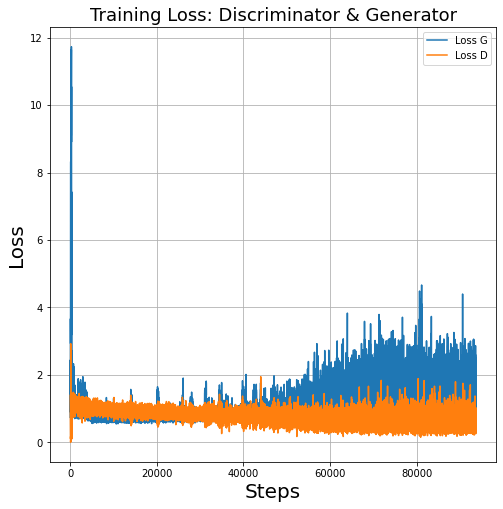

In [44]:
plt.figure(figsize=(8,8))
plt.plot(range(step),loss_G_lis[:step], label="Loss G")
plt.plot(range(step),loss_D_lis[:step], label="Loss D")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("Training Loss: Discriminator & Generator", fontsize=18)
plt.legend()
plt.grid()
plt.show()

Comments: here, epoch = steps / dataloader_size (1875). 

We notice that both the generator and disciminator's loss both decreased, especially, the discriminator performs better than the generator, which can be seen more towards the end of training. 

In [ ]:
# plt.figure(figsize=(8,8))
# # plt.plot(range(step),loss_D_lis[:step], label="Loss D")
# # plt.plot(range(step),loss_G_lis[:step], label="Loss G")
# plt.plot(np.arange(MAX_EPOCHS),epoch_loss_G, label="Loss G")
# plt.plot(np.arange(MAX_EPOCHS),epoch_loss_D, label="Loss D")
# # plt.xlabel("Steps", fontsize=20)
# plt.xlabel("Epochs", fontsize=20)
# plt.ylabel("Loss", fontsize=20)
# plt.title("Training Loss: Discriminator & Generator", fontsize=18)
# plt.legend()
# plt.grid()
# plt.show()